# Exploring the UTx000 Extension Beacon Data
(Known as BPEACE2 in the [GH repo](https://github.com/intelligent-environments-lab/utx000))

# GPS Restriction
Although a weird notebook to start with, we being the journey of exploring the beacon data by finding beacon data during which the Beiwe GPS is near the participants' homes. 

# Package Import

In [2]:
import sys
sys.path.append('../')

from src.features import build_features
from src.visualization import visualize
from src.reports import make_report

import pandas as pd
import numpy as np

from datetime import datetime, timedelta

# Data Import

In [3]:
id_crossover = pd.read_excel('../data/raw/bpeace2/admin/id_crossover.xlsx',sheet_name='beacon',parse_dates=[3,4,5])
# show if off:
id_crossover.head()

,REDCap,Beiwe,Beacon,start_date,end_date,move_date,Lat,Long,original_start,original_end,original_move
0,10,kyj367pi,1,2020-06-08,2020-09-03,2020-07-31,30.312614,-97.732338,2020-06-06,2020-09-03,2020-07-31
1,55,745vq78e,5,2020-06-08,2020-08-23,NaT,30.288012,-97.751201,2020-06-08,2020-09-09,2020-09-09
2,61,itmylz3g,6,2020-06-15,NaT,NaT,29.855371,-95.741200,2020-06-15,NaT,2020-09-14
3,0,zdpffrox,7,2020-06-02,2020-09-14,NaT,30.326815,-97.744665,2020-06-02,2020-09-14,2020-09-14
4,43,xlw5ntd5,10,2020-06-08,2020-09-11,2020-08-10,30.351693,-97.614524,2020-06-06,NaT,2020-08-10


In [4]:
beacon_data = pd.read_csv('../data/processed/bpeace2-beacon.csv',index_col=0,parse_dates=True)
# show it off:
beacon_data.head()

,TVOC,eCO2,Lux,Visible,Infrared,NO2,T_NO2,RH_NO2,CO,T_CO,...,PM_N_4,PM_N_10,PM_C_1,PM_C_2p5,PM_C_4,PM_C_10,Beacon,Beiwe,Fitbit,REDCap
Timestamp,,,,,,,,,,,,,,,,,,,,,
2020-06-11 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,30,idbkjh8u,22,4
2020-06-11 00:05:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,30,idbkjh8u,22,4
2020-06-11 00:10:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,30,idbkjh8u,22,4
2020-06-11 00:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,30,idbkjh8u,22,4
2020-06-11 00:20:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,30,idbkjh8u,22,4


In [5]:
gps_data = pd.read_csv('../data/processed/bpeace2-gps.csv',index_col=0,parse_dates=True)
# show it off:
gps_data.head()

,Lat,Long,Alt,Accuracy,X_Distance,Y_Distance,Distance_Home,Beiwe
Time,,,,,,,,
2020-06-01 10:35:00,32.92302,-96.96281,152.32799,65.0,9.008819,255.425866,255.584686,2xtqkfz1
2020-06-02 00:15:00,32.92308,-96.96284,152.04933,65.0,2.928626,252.090018,252.107029,2xtqkfz1
2020-06-04 05:40:00,32.94166,-96.97102,161.00000,2500.0,1879.904447,657.484482,1991.563851,2xtqkfz1
2020-06-05 02:15:00,32.89644,-96.97102,131.00000,2500.0,2702.534281,657.484482,2781.362505,2xtqkfz1
2020-06-05 06:30:00,32.89644,-96.97102,152.00000,2500.0,2702.534281,657.484482,2781.362505,2xtqkfz1


## Other Important Variables

In [6]:
compensation_dates = [datetime(2020,6,9), datetime(2020,6,30), datetime(2020,8,12)]

# Restricting the Beacon Data
We need to restrict the beacon data according to a few critera that are in an order such that criteria 3 is the most restricting:
1. participants actually had the beacons
2. participants were home
3. participants were at their original or secondary address (whichever gives us the most data)

## Participants had the Beacons
We have the approximate windows during which the participants had the beacons. We can visually inspect the data to confirm/modify the dates.

In [7]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

The following cell produces figures that help identify when the beacons were operating for the various participants and help to identify any problems with sensors or timing in addition to whether or not the participants left their original addresss. See full reports [here](https://github.com/intelligent-environments-lab/utx000/blob/master/reports/bpeace2-operation-check.md).

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy

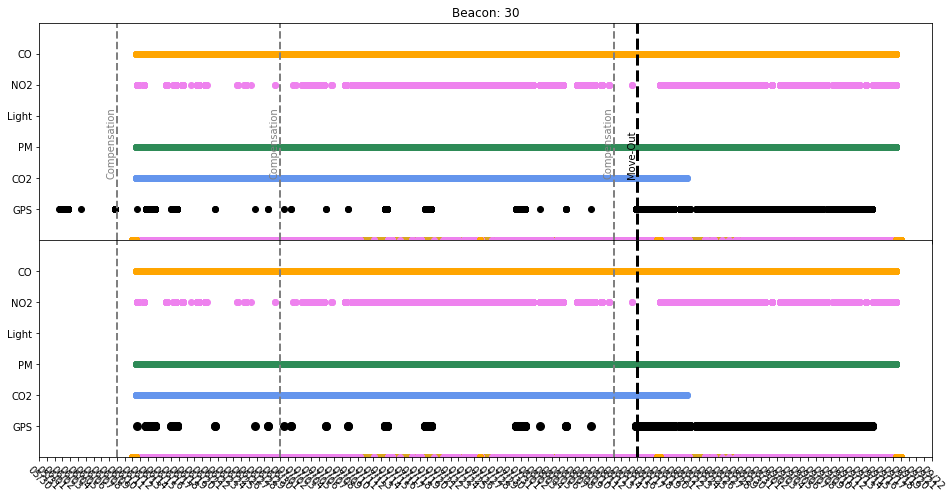

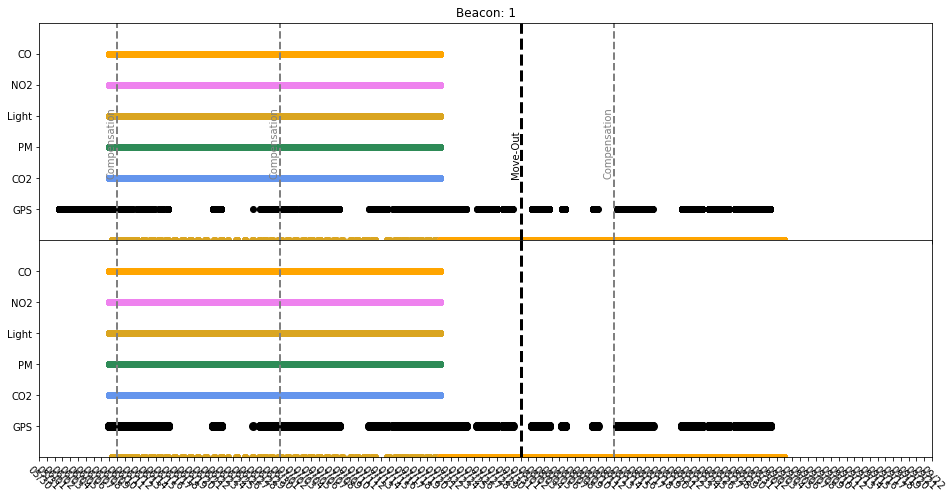

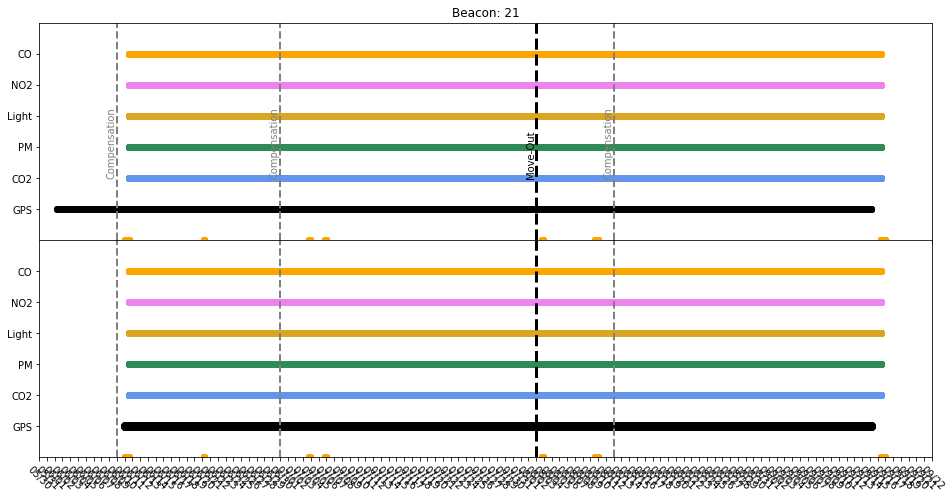

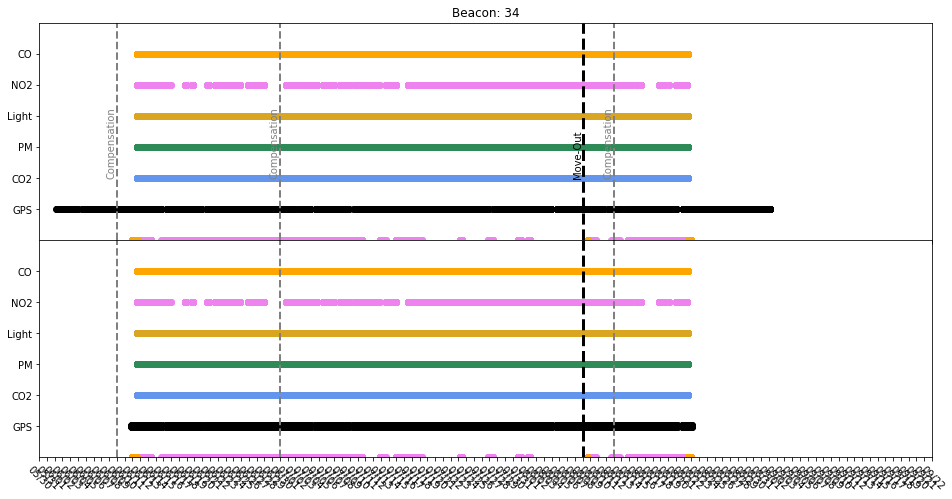

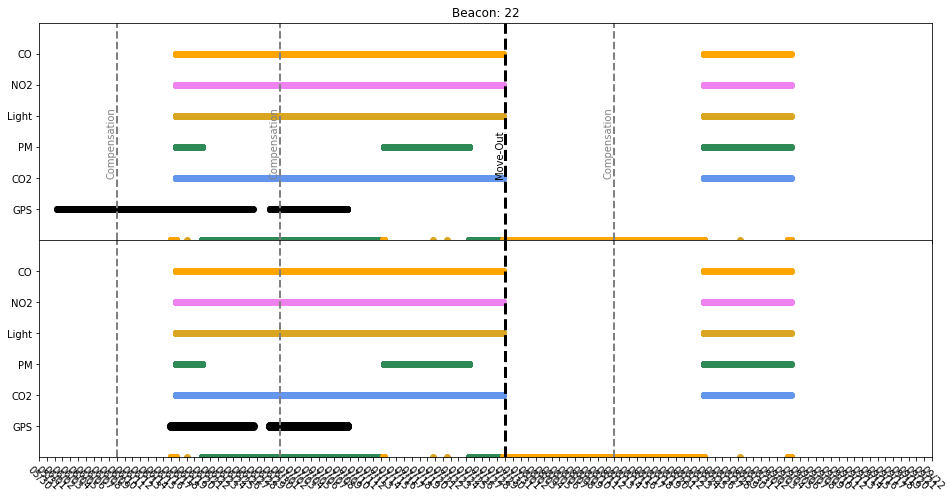

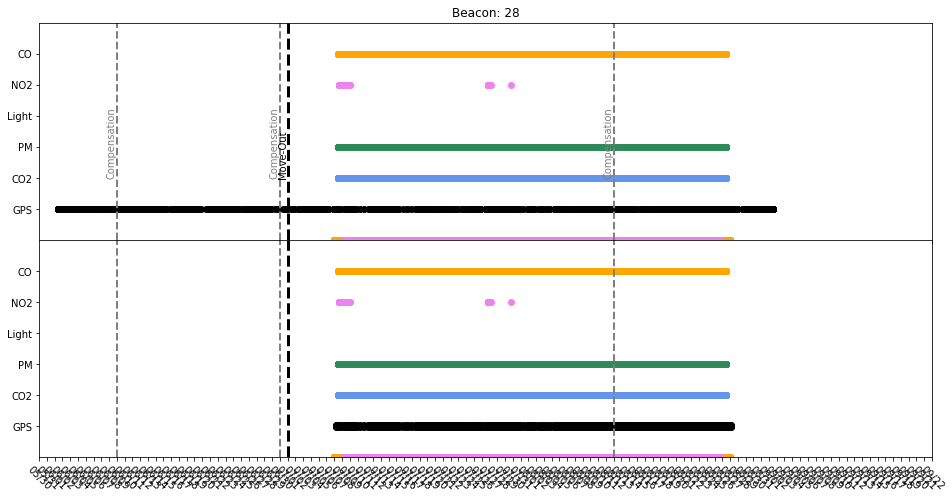

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


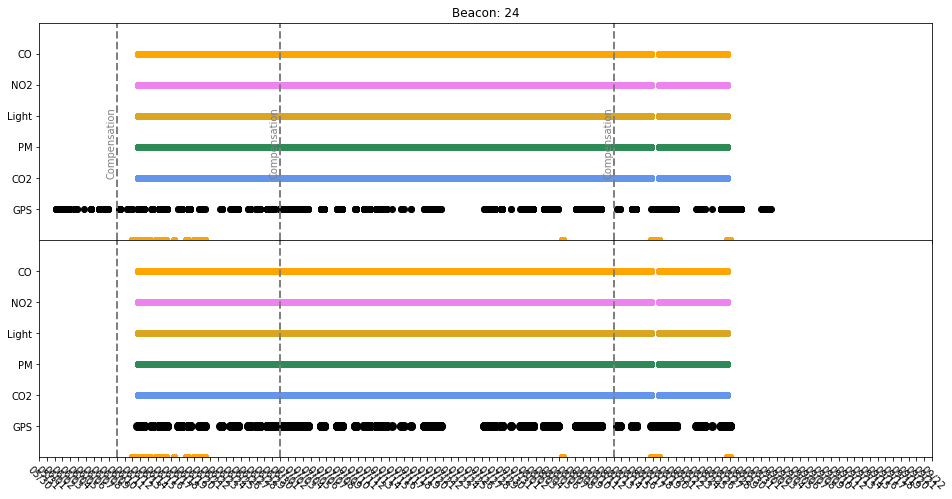

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


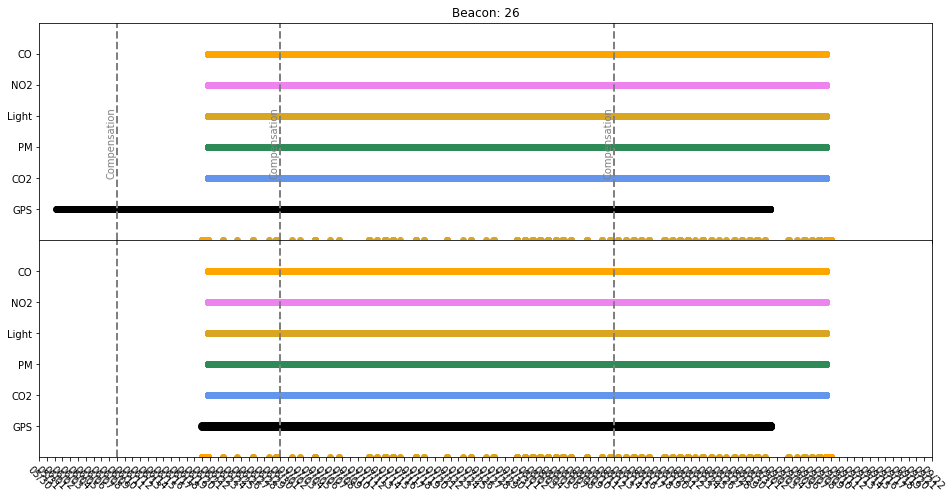

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


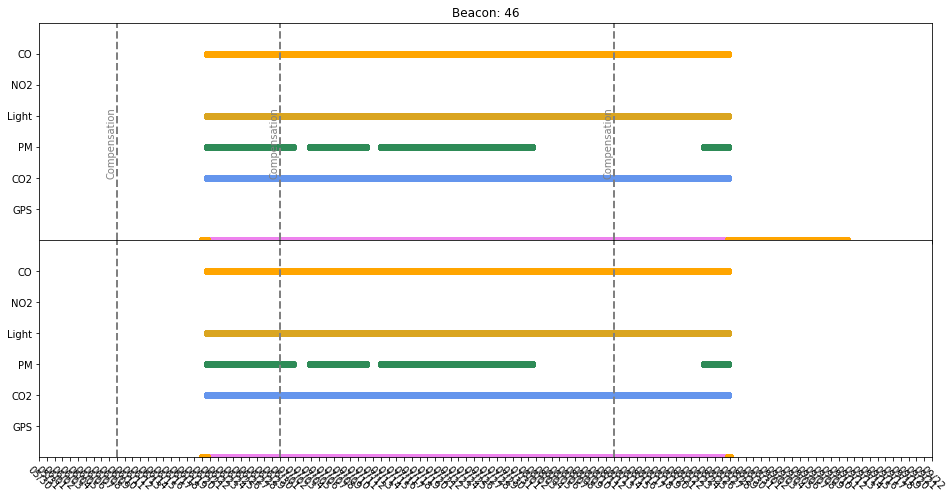

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


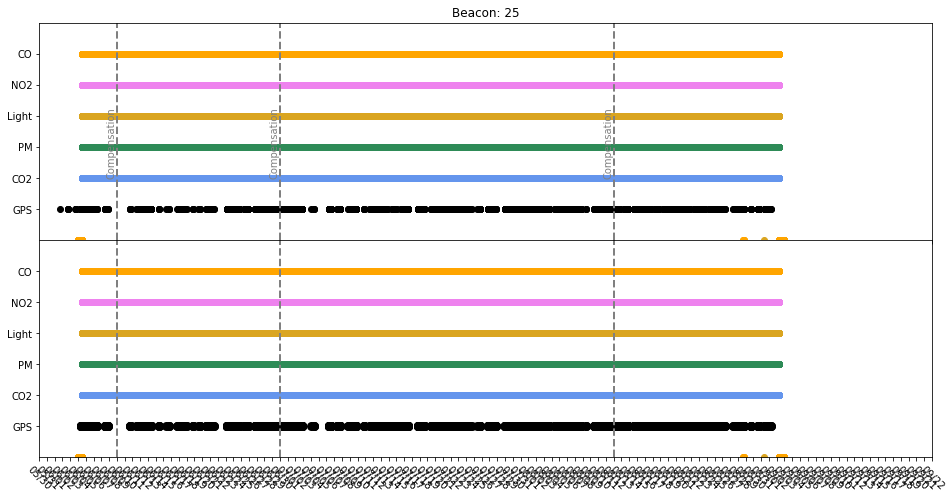

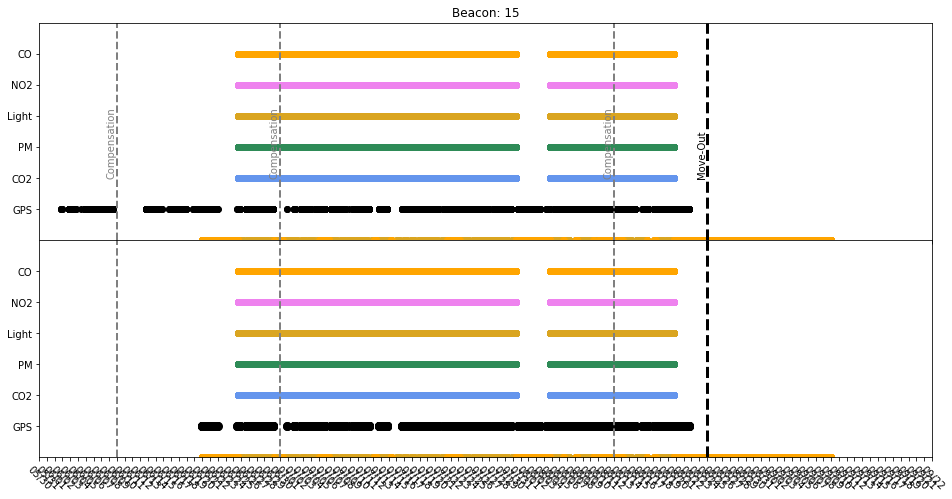

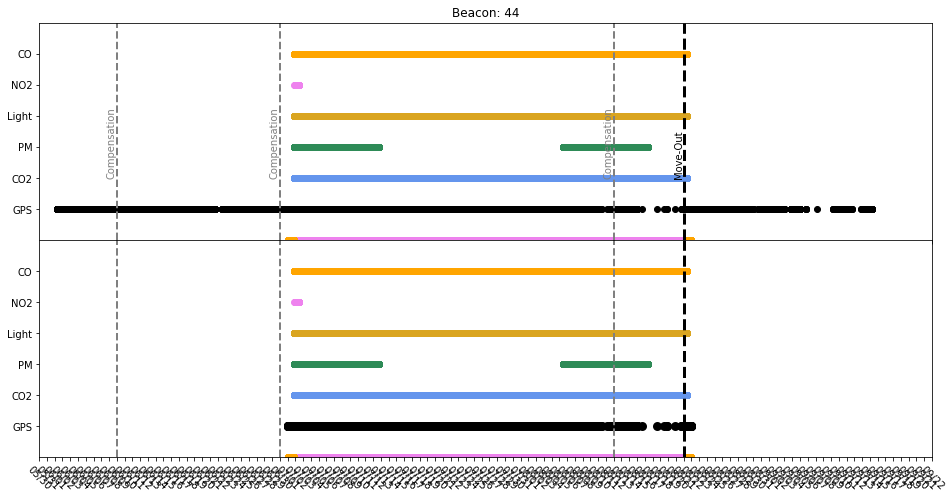

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


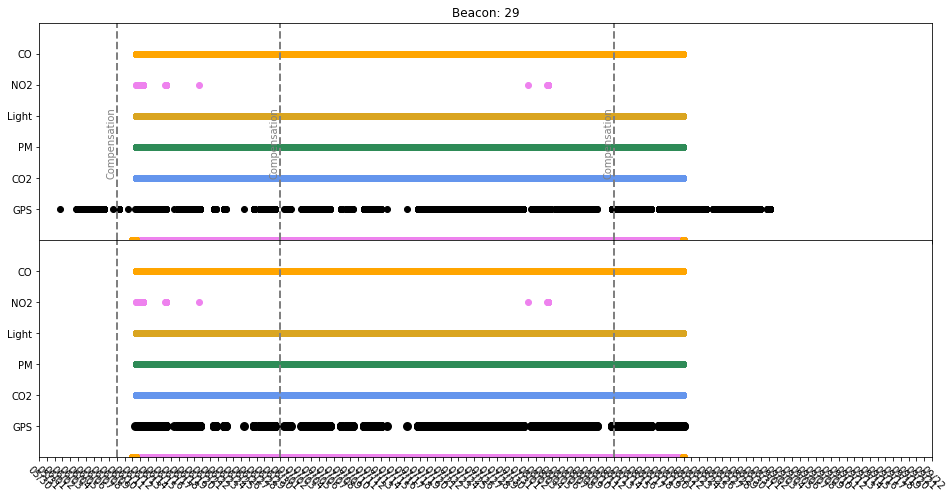

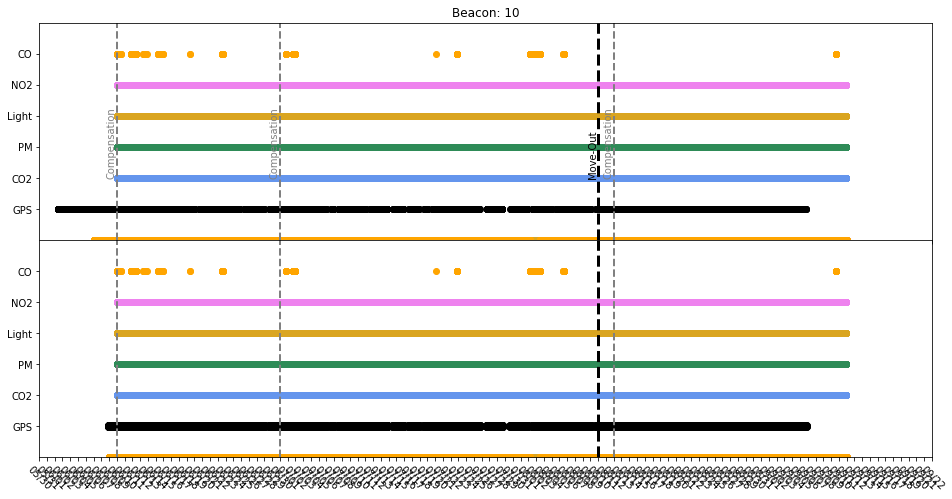

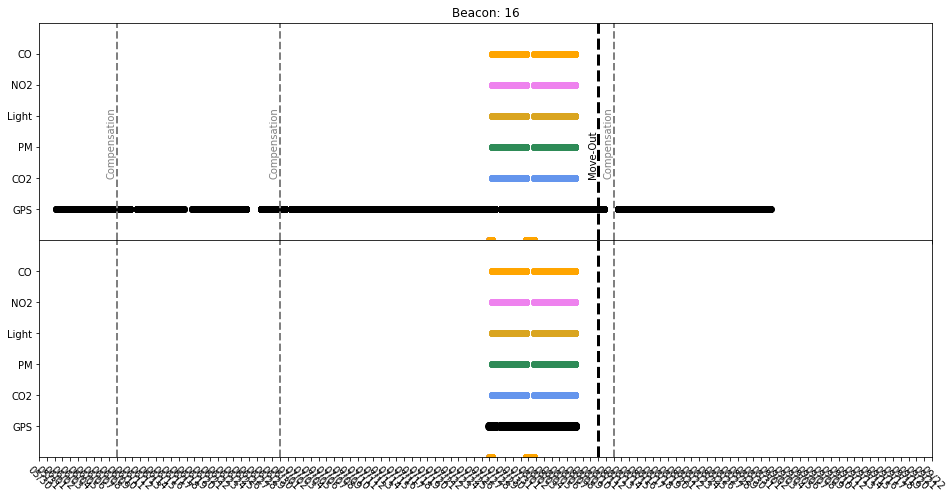

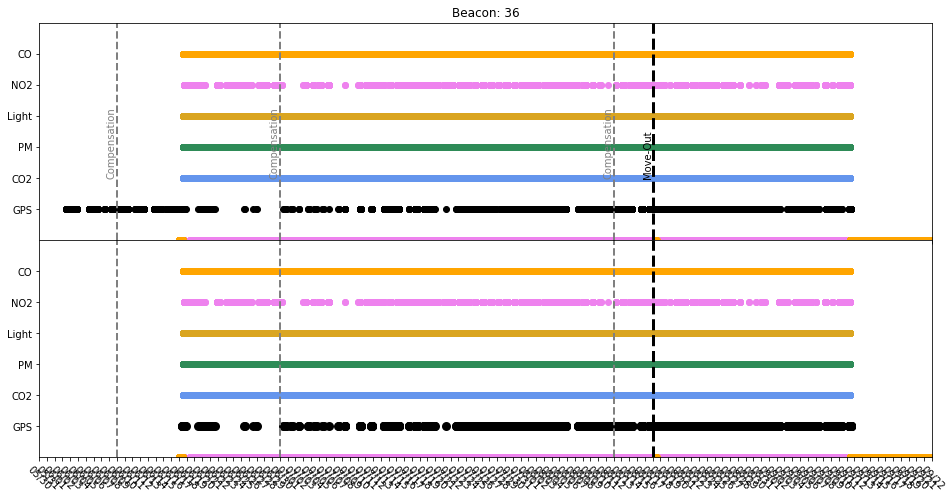

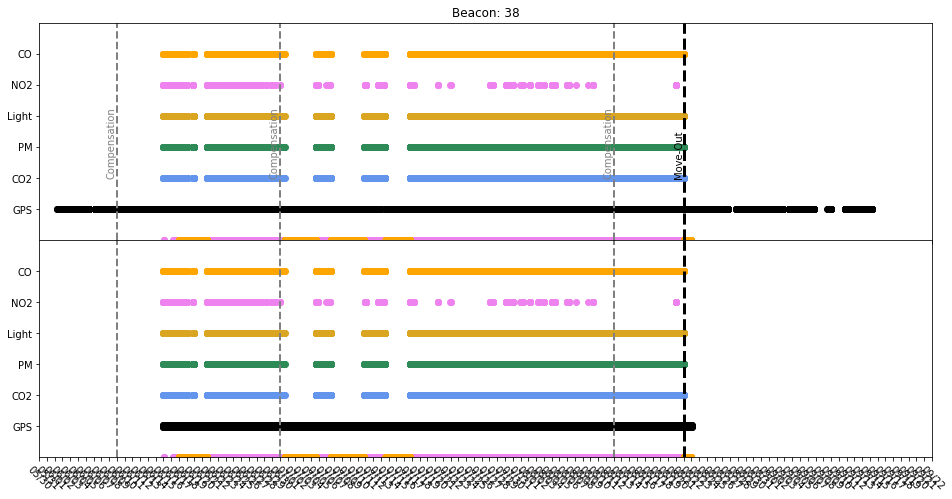

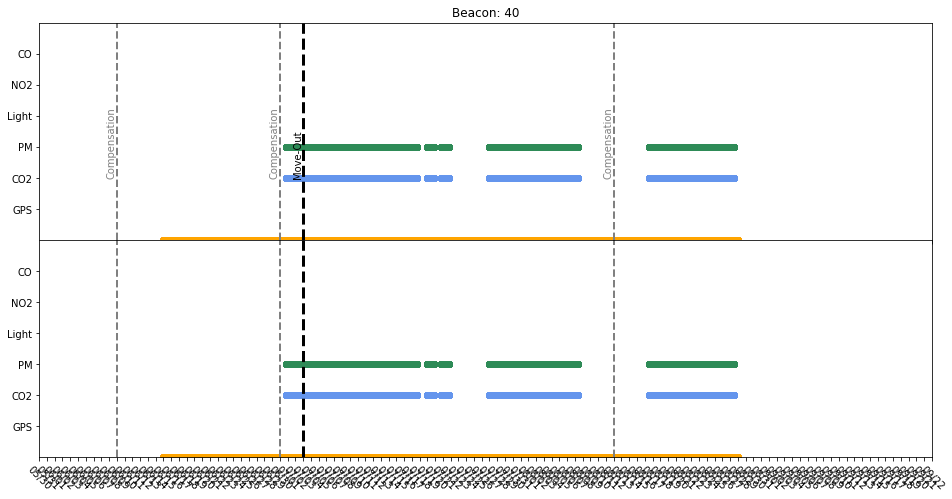

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


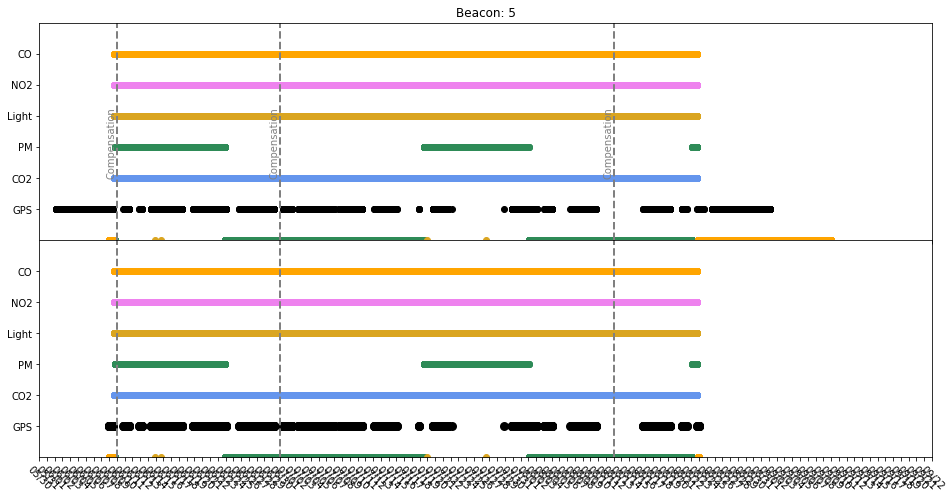

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


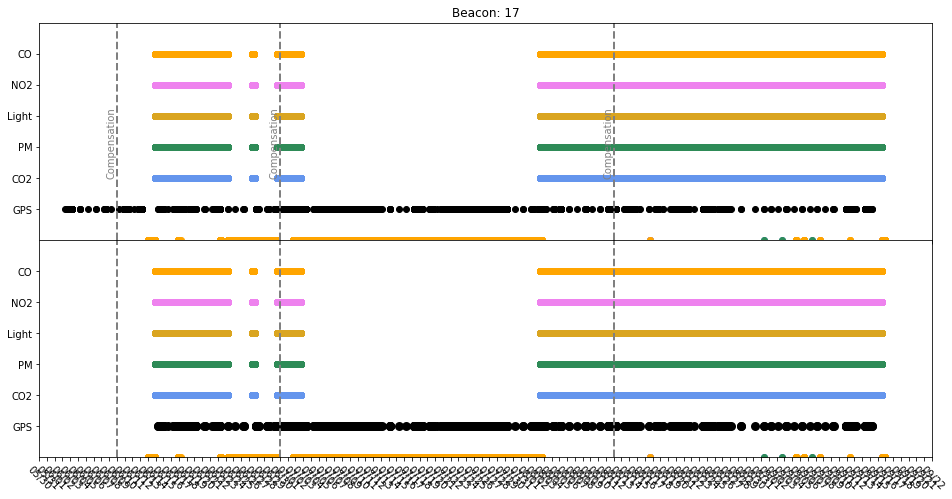

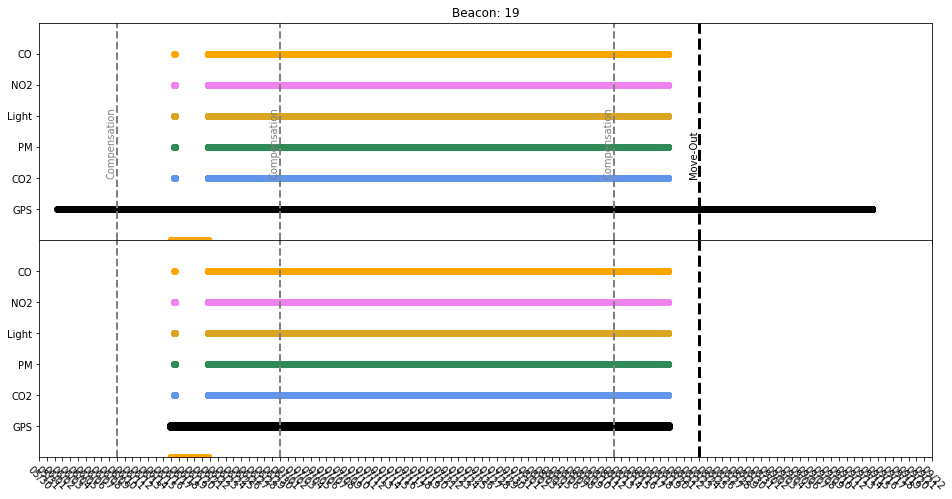

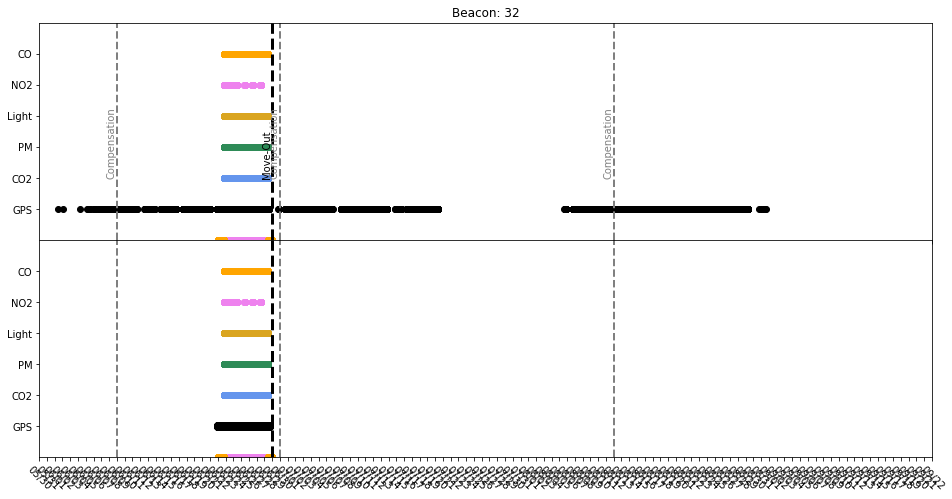

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


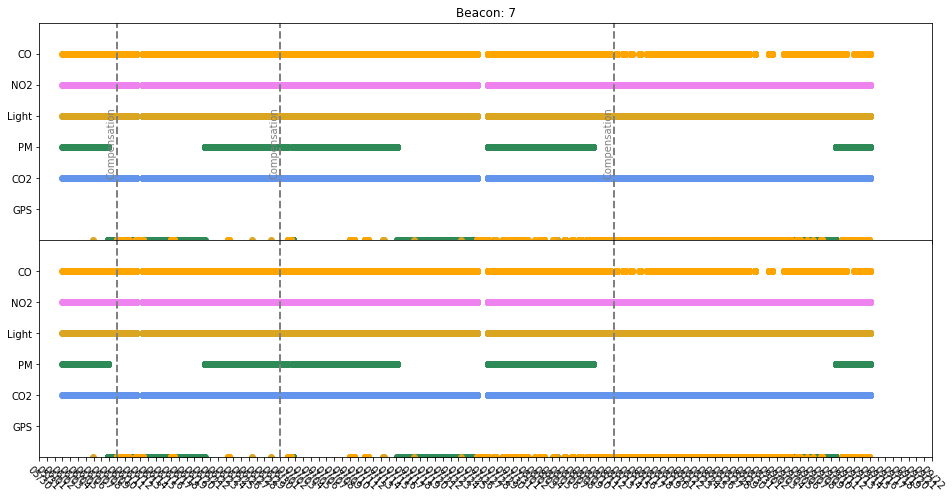

In [11]:
for beiwe in beacon_data['Beiwe'].unique():
    
    gps_by_beiwe = gps_data[gps_data['Beiwe'] == beiwe]
    gps_by_beiwe['GPS_op'] = np.select([pd.to_numeric(gps_by_beiwe['Lat'],errors='coerce') > 0],[1])
    
    beacon_by_beiwe = beacon_data[beacon_data['Beiwe'] == beiwe]
    beacon_by_beiwe['CO2_op'] = np.select([pd.to_numeric(beacon_by_beiwe['CO2'],errors='coerce') > 0],[2])
    beacon_by_beiwe['PM_op'] = np.select([pd.to_numeric(beacon_by_beiwe['PM_C_2p5'],errors='coerce') > 0],[3])
    beacon_by_beiwe['Lux_op'] = np.select([pd.to_numeric(beacon_by_beiwe['Lux'],errors='coerce') > -10],[4])
    beacon_by_beiwe['NO2_op'] = np.select([pd.to_numeric(beacon_by_beiwe['NO2'],errors='coerce') > -5],[5])
    beacon_by_beiwe['CO_op'] = np.select([pd.to_numeric(beacon_by_beiwe['CO'],errors='coerce') > -5],[6])
    
    b = beacon_by_beiwe['Beacon'][0]
    
    start_date = id_crossover[id_crossover['Beiwe'] == beiwe]['start_date'].values[0]
    end_date = id_crossover[id_crossover['Beiwe'] == beiwe]['end_date'].values[0]
    move_date = id_crossover[id_crossover['Beiwe'] == beiwe]['move_date'].values[0]
    
    if np.isnat(end_date):
        print(f'Beacon {b}: No end date')
    else:
        beacon_by_beiwe_study = beacon_by_beiwe[start_date:end_date]
        gps_by_beiwe_study = gps_by_beiwe[start_date:end_date]
        
        fig,ax = plt.subplots(2,1,figsize=(16,8),sharex=True,sharey=True)
        
        # Available data
        avail_ax = ax[0]
        avail_ax.scatter(gps_by_beiwe.index,gps_by_beiwe['GPS_op'],color='black')
        avail_ax.scatter(beacon_by_beiwe.index,beacon_by_beiwe['CO2_op'],color='cornflowerblue')
        avail_ax.scatter(beacon_by_beiwe.index,beacon_by_beiwe['PM_op'],color='seagreen')
        avail_ax.scatter(beacon_by_beiwe.index,beacon_by_beiwe['Lux_op'],color='goldenrod')
        avail_ax.scatter(beacon_by_beiwe.index,beacon_by_beiwe['NO2_op'],color='violet')
        avail_ax.scatter(beacon_by_beiwe.index,beacon_by_beiwe['CO_op'],color='orange')
        
        ## Formatting top plot
        avail_ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
        avail_ax.xaxis.set_major_locator(mdates.DayLocator())
        avail_ax.set_title(f'Beacon: {b}')
        avail_ax.set_xlim([datetime(2020,5,30),datetime(2020,9,22)])
        avail_ax.set_ylim([0,7])
        plt.yticks([1,2,3,4,5,6],['GPS','CO2','PM','Light','NO2','CO'])
        
        ## Annotating with important dates
        avail_ax.axvline(move_date,color='black',linewidth=3,linestyle='dashed')
        for d in compensation_dates:
            avail_ax.axvline(d,color='gray',linewidth=2,linestyle='dashed')
            avail_ax.text(d,2,'Compensation',va='bottom',ha='right',rotation='vertical',color='gray')    
        avail_ax.text(move_date,2,'Move-Out',va='bottom',ha='right',rotation='vertical')
        
        # Beginning Restricted data
        restrict_ax = ax[1]
        restrict_ax.scatter(gps_by_beiwe_study.index,gps_by_beiwe_study['GPS_op'],linewidth=3,color='black')
        restrict_ax.scatter(beacon_by_beiwe_study.index,beacon_by_beiwe_study['CO2_op'],color='cornflowerblue')
        restrict_ax.scatter(beacon_by_beiwe_study.index,beacon_by_beiwe_study['PM_op'],color='seagreen')
        restrict_ax.scatter(beacon_by_beiwe_study.index,beacon_by_beiwe_study['Lux_op'],color='goldenrod')
        restrict_ax.scatter(beacon_by_beiwe_study.index,beacon_by_beiwe_study['NO2_op'],color='violet')
        restrict_ax.scatter(beacon_by_beiwe_study.index,beacon_by_beiwe_study['CO_op'],color='orange')
        
        ## Formatting bottom plot
        restrict_ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
        restrict_ax.xaxis.set_major_locator(mdates.DayLocator())
        restrict_ax.tick_params(axis='x',labelrotation=-45)
        restrict_ax.set_ylim([0,7])
        plt.yticks([1,2,3,4,5,6],['GPS','CO2','PM','Light','NO2','CO'])
        
        ## Annotating
        restrict_ax.axvline(move_date,color='black',linewidth=3,linestyle='dashed')
        for d in compensation_dates:
            restrict_ax.axvline(d,color='gray',linewidth=2,linestyle='dashed')
        
        # adjusting and saving
        plt.subplots_adjust(hspace=0)
        plt.savefig(f'../reports/bpeace2_operation/beacon{b}_operation_schedule.png')
        plt.show()
        plt.close()

## Participants were home
Using the addresses provided, we can now limit the data used in analysis based on when the participants were home.

For each participant:
1. get the GPS coordinates of their home
2. determine the distance from each point of their Beiwe GPS records to their home location
3. remove points greater than a certain distance and merge the gps data points with the beacon data only keeping the overlap
5. plot

### 1. GPS Coordinates of Participants' Homes
The GPS coordinates were determined already and tabulated in the id_crossover Excel sheet on the "Beacon" sheet.

In [9]:
print('Beiwe ID\tLatitude\tLongitude\n--------\t--------\t---------')
for pid, lat, long in zip(id_crossover['Beiwe'],id_crossover['Lat'],id_crossover['Long']):
    print(f'{pid}\t{lat}\t{long}')

Beiwe ID	Latitude	Longitude
--------	--------	---------
kyj367pi	30.3126141	-97.732338
745vq78e	30.288012	-97.7512011
itmylz3g	29.8553707	-95.7412
zdpffrox	30.3268152	-97.7446653
xlw5ntd5	30.3516931	-97.614524
i31pt4b4	30.2901655	-97.7526442
mm69prai	30.2864605	-97.7130557
qh34m4r9	33.1613206	-96.8763475
e73a1pd5	30.2932255	-97.7476455
9xmhtq74	30.7585332	-94.4207243
9jtzsuu8	33.1419407	-97.1155623
lkkjddam	30.5883841	-97.4280508
xxvnhauv	30.353628	-97.7623856
5fvmg226	30.2403908	-97.7203098
xdbdrk6e	33.1364658	-96.6273608
vr9j5rry	30.3565653	-97.7544778
awa8uces	30.0493663	-95.507686
hxj6brwj	30.2802629	-97.7440499
tmexej5v	30.396407	-97.6464253
idbkjh8u	30.2846247	-97.7494186
2xtqkfz1	32.9231089	-96.9651071
rnse61g4	30.290757	-97.7456838
tlmlq19s	30.3057674	-97.7249662
olaxadz5	30.239693	-97.7145425
i4w8dx6l	30.3122943	-97.7315
hcpu5myv	32.7064908	-97.6943513
4i7679py	33.0358971	-96.6559366
nvtfpaor	27.6025391	-99.4637369
rj4lxgvp	30.286894	-97.7489093


### ~~2. Determining distance to each point~~
The distance can be determined by using the following formula if we assume a "flat" Earch which is reasonable given our small distances:

$$
x = R(a_2-a_1)\frac{\pi}{180}\cos(b_1) \\
y = R(b_2-b_1)\frac{\pi}{180}
$$

where $R$ is the radius of the earth and we have two coordinates in (lat, long) format: $(a_1,a_2)$ and $(b_1,b_2)$. These equations were pulled from this [website](http://mathforum.org/library/drmath/view/51833.html).

In [8]:
import math
R = 6.371*10**6

for pid in gps_data['Beiwe'].unique():
    gps_data_by_beiwe = gps_data[gps_data['Beiwe'] == pid]
    home_coords = id_crossover.set_index('Beiwe')
    home_lat = home_coords.loc[pid,'Lat']
    home_long = home_coords.loc[pid,'Long']
    
    gps_data_by_beiwe['x'] = abs( R * (gps_data_by_beiwe['Lat'] - home_lat) * math.pi * math.cos(home_long) / 180) 
    gps_data_by_beiwe['y'] = abs( R * (gps_data_by_beiwe['Long'] - home_long) * math.pi / 180) 
    dist = []
    for i in range(len(gps_data_by_beiwe)):
        dist.append(math.sqrt(math.pow(gps_data_by_beiwe.iloc[i,-2],2) + math.pow(gps_data_by_beiwe.iloc[i,-1],2)))
        
    gps_data_by_beiwe['dist'] = dist

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:16: 

The above code is now included in the ```make_dataset``` function and thus comes along with the import of the processed GPS data. **TLDR**: Don't run the above cell.

### 3. Throw out distances greater than a certain amount and merge with beacon data

In [9]:
def get_home_beacon_data(beacon_data,gps_data,distance_threshold=100):
    '''
    Gets the beacon data for participants that are considered "home"
    '''
    
    gps_data_filtered = gps_data[gps_data['Distance_Home'] <= 100]

    home_beacon_data = pd.DataFrame() # stores beacon data when participants are home
    for pid in beacon_data['Beiwe'].unique():
        beacon_data_by_beiwe = beacon_data[beacon_data['Beiwe'] == pid]
        beacon_data_by_beiwe.dropna(inplace=True)
        gps_data_by_beiwe = gps_data_filtered[gps_data_filtered['Beiwe'] == pid]
        home_beacon_data_by_beiwe = pd.merge(left=beacon_data_by_beiwe,right=gps_data_by_beiwe,
                                             left_index=True,right_index=True,
                                             how='inner',copy=False)

        home_beacon_data = home_beacon_data.append(home_beacon_data_by_beiwe)
        
    home_beacon_data['Beiwe'] = home_beacon_data['Beiwe_x']
    home_beacon_data.drop(['Beiwe_x','Beiwe_y'],axis=1,inplace=True)
        
    return home_beacon_data
    

### 4. Plotting
With heatmaps!

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


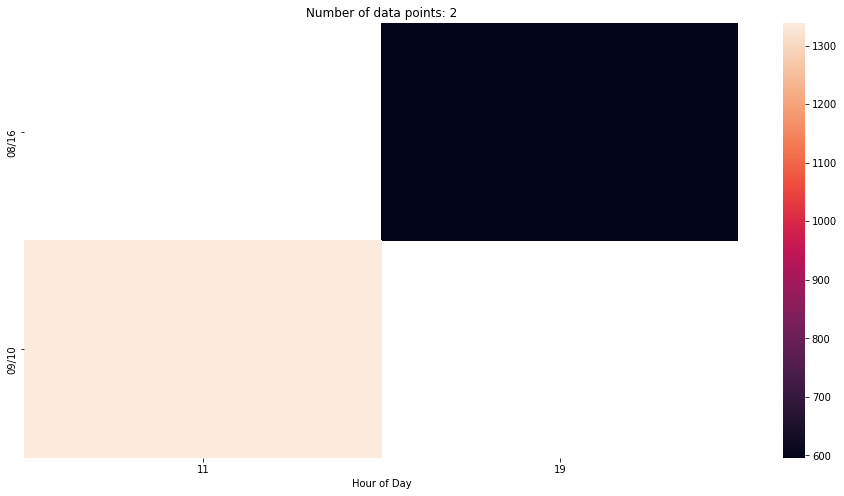

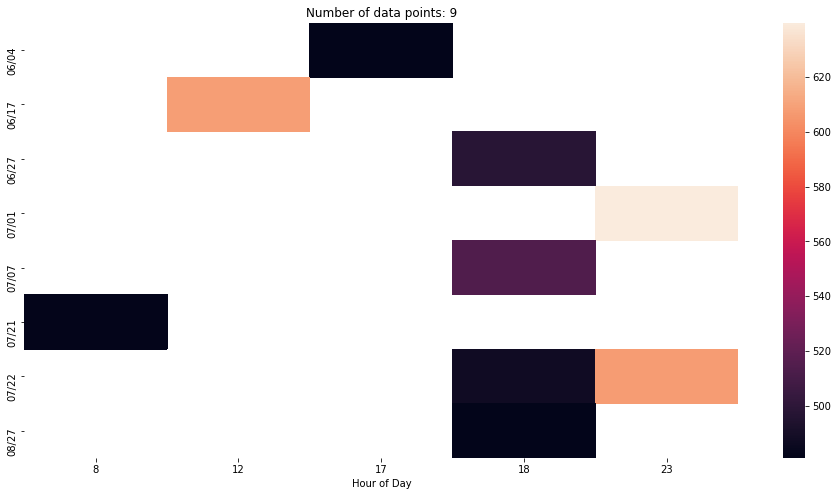

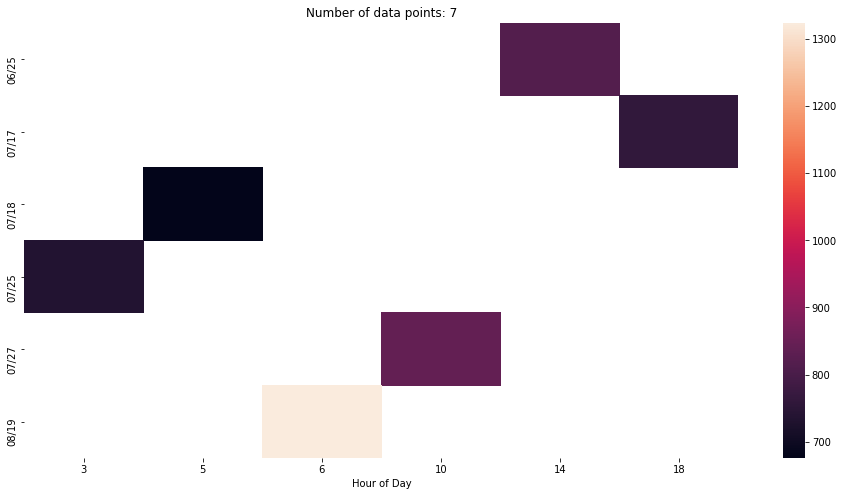

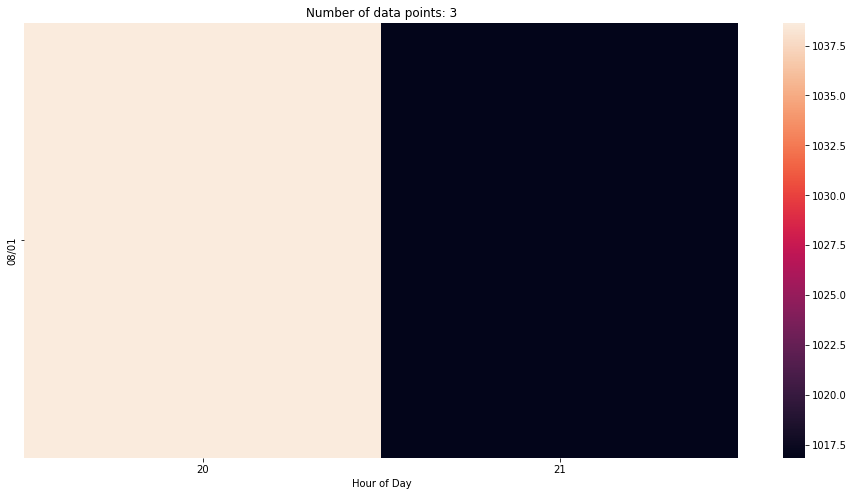

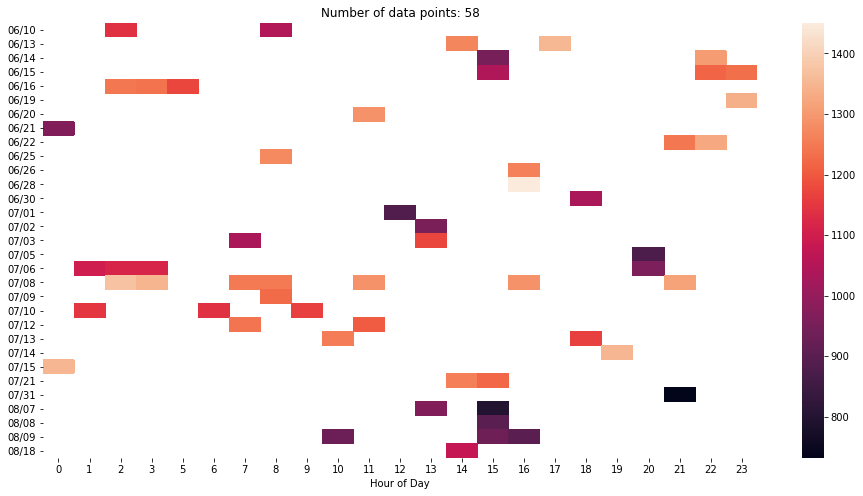

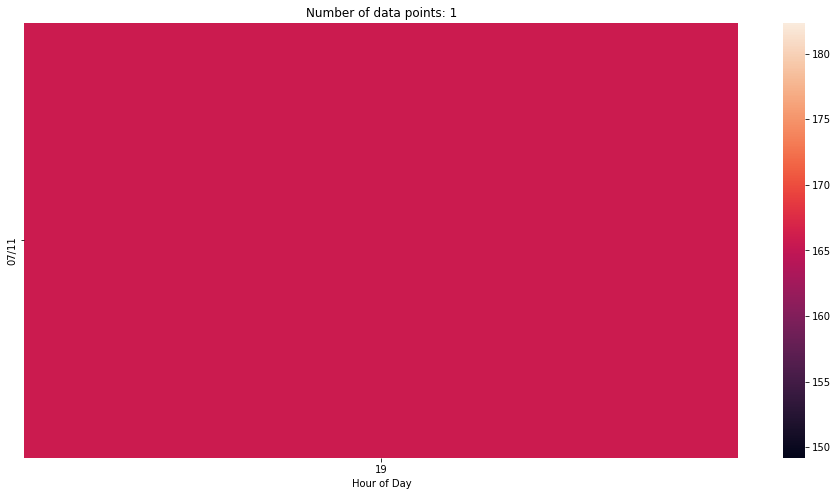

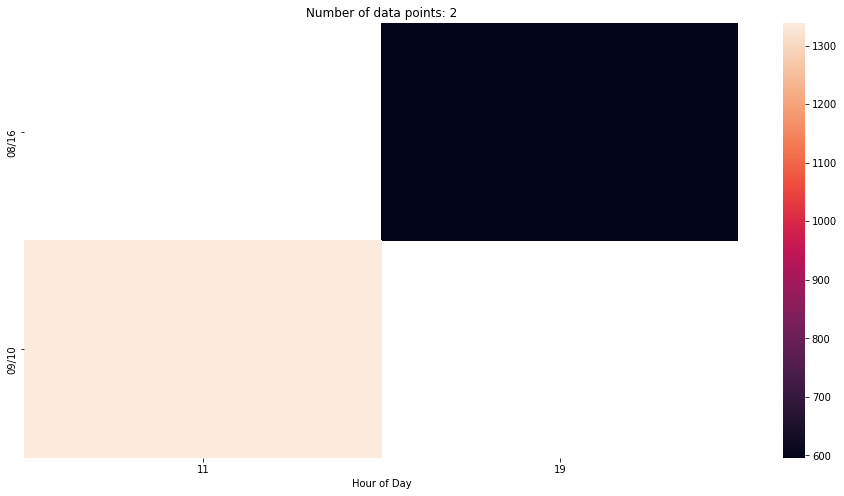

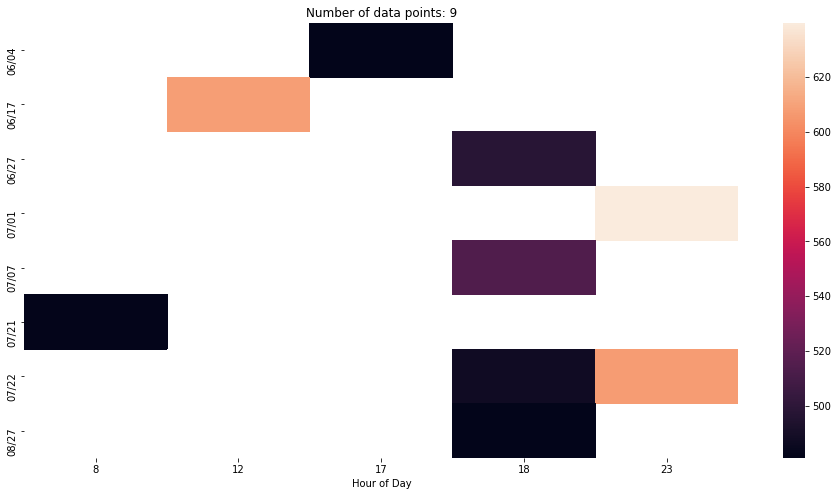

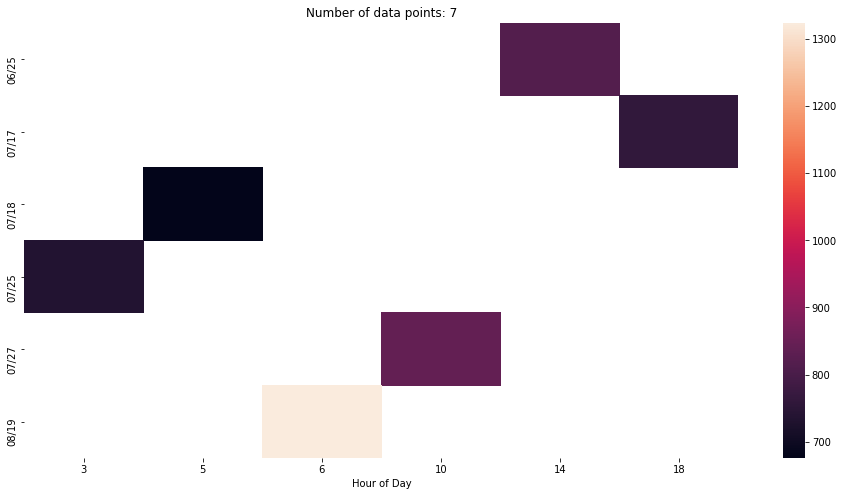

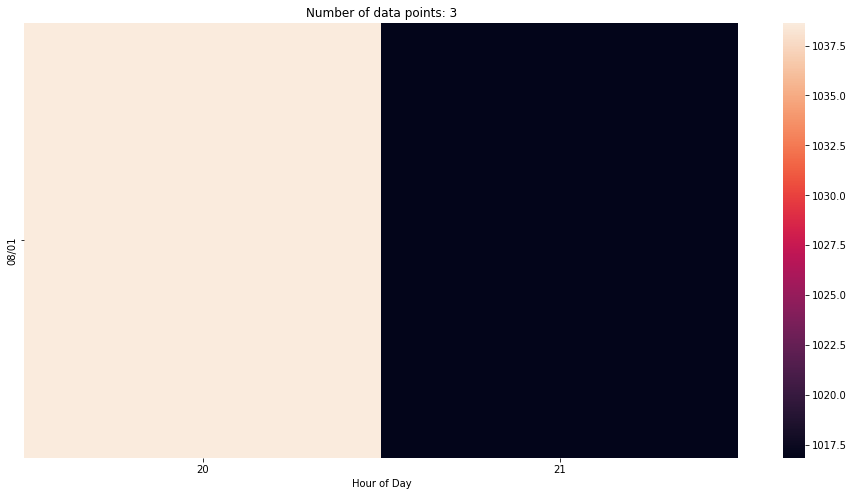

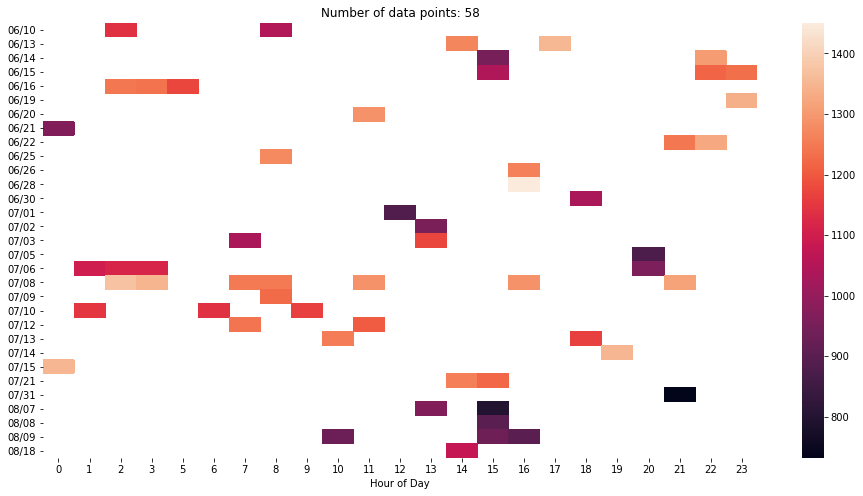

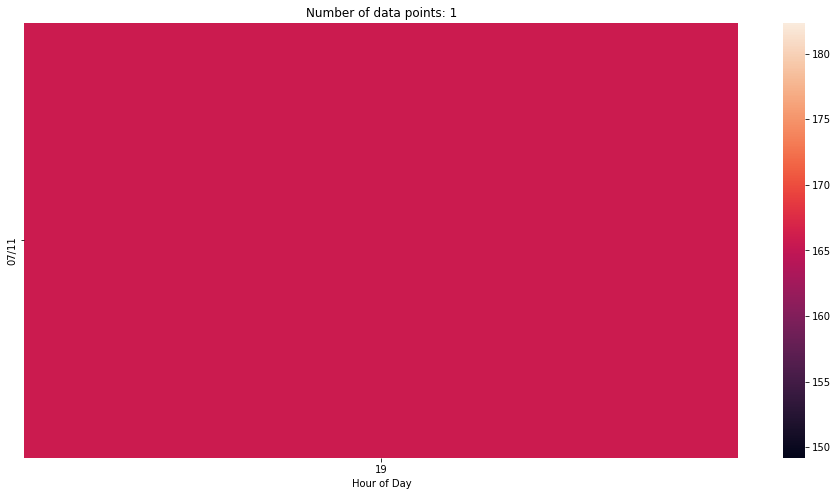

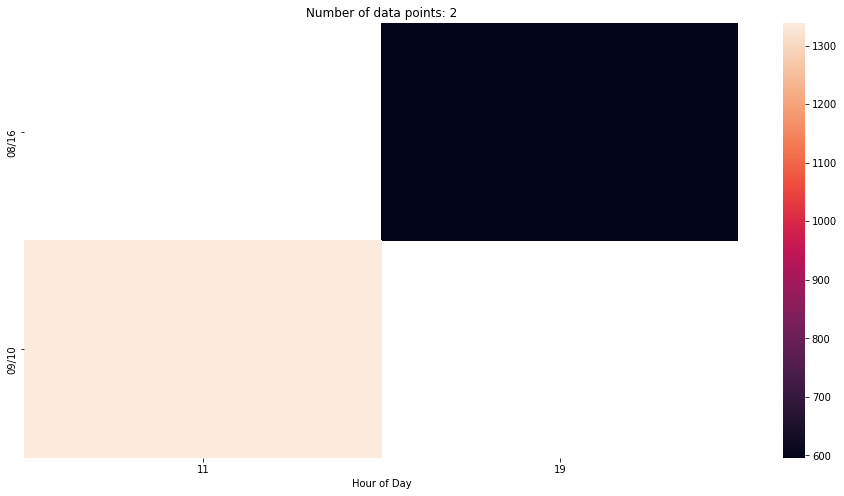

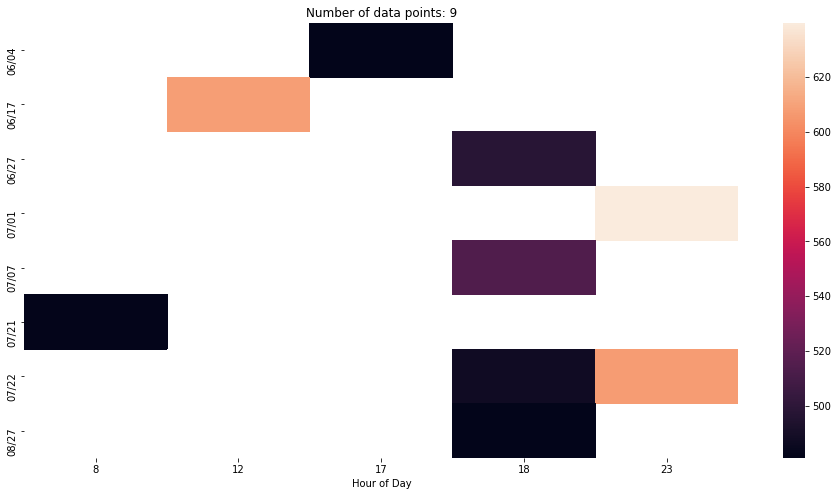

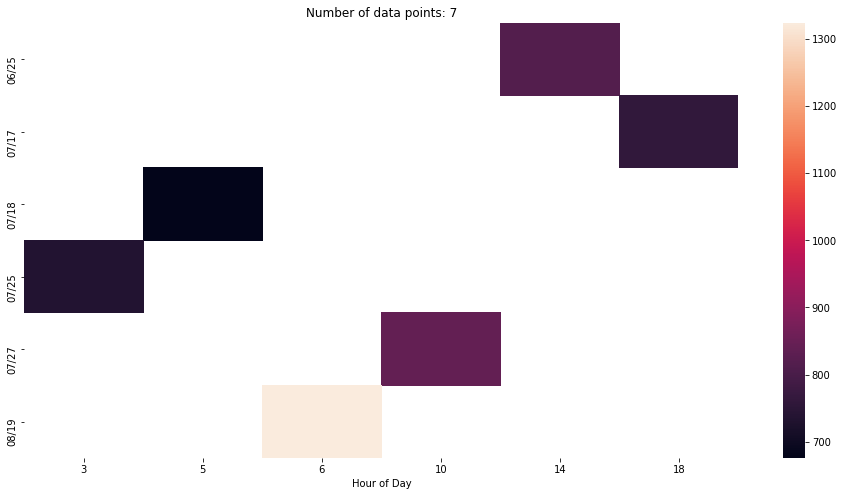

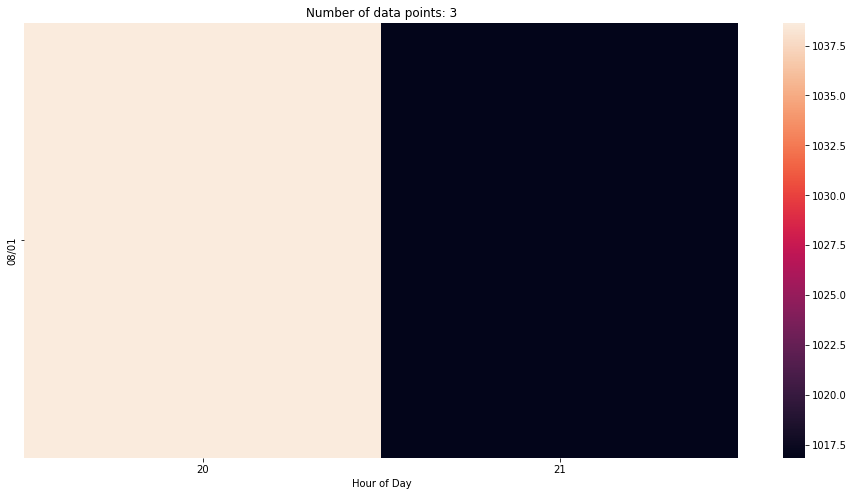

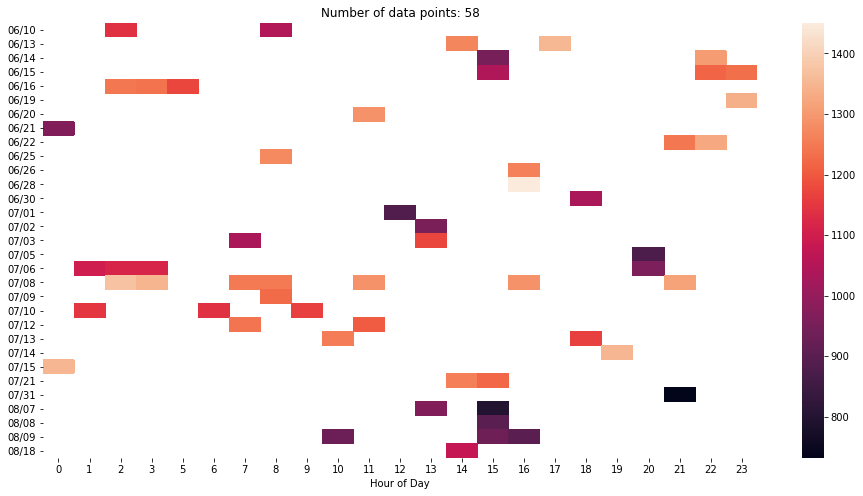

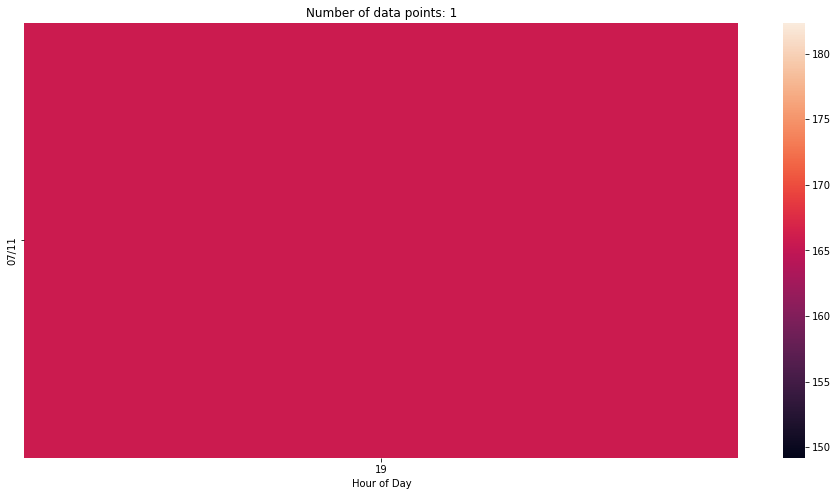

In [10]:
plotter = visualize.single_var('bpeace2')
for threshold in [100,200,500]:
    home_beacon_data = get_home_beacon_data(beacon_data,gps_data,threshold)
    for pid in home_beacon_data['Beiwe'].unique():
        home_beacon_data_by_beiwe = home_beacon_data[home_beacon_data['Beiwe'] == pid]
        for column in ['CO2']:#['TVOC','Lux','NO2','CO','CO2','PM_C_2p5']:
            fig, ax = plotter.heatmap(home_beacon_data_by_beiwe,column)
            ax.set_title(f'Number of data points: {len(home_beacon_data_by_beiwe)}')
            plt.show()
            plt.close()